# Imports 

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [6]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

Generating train split: 100%|██████████| 72134/72134 [00:00<00:00, 815992.12 examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length'],
        num_rows: 72134
    })
})


## Split dataset

In [7]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

       label  has_quotes  has_url  percent_uppercase  frequency_punctuation  \
0          1           0        1           3.188750                    182   
1          1           0        0           4.347826                      1   
2          1           0        0           2.314815                      2   
3          0           0        1           3.071161                    154   
4          1           0        1           6.419624                     42   
...      ...         ...      ...                ...                    ...   
72129      0           0        1           3.801170                    105   
72130      1           0        1           3.302146                     51   
72131      0           1        0           3.666201                     85   
72132      0           0        1           3.704801                     73   
72133      1           0        0           3.945428                     62   

       percent_whitespace  frequency_words_length_1

In [10]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_punctuation  \
22156           1        1           4.200000                     78   
46603           0        1          10.169492                     11   
22381           0        1           5.925030                     32   
13489           0        1           4.518848                     86   
40644           0        1           2.686404                     30   
...           ...      ...                ...                    ...   
12895           0        1           3.796928                     38   
60960           0        1           6.216216                     12   
6012            0        1           3.363914                     40   
63107           0        1           3.407657                     45   
6558            0        0           5.263158                      8   

       percent_whitespace  frequency_words_length_15  \
22156           15.500000                          0   
46603            0.0000

### Training

no further preprocessing

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
# scale features
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [17]:
# instantiate with default params first
gnb = GaussianNB()
gnb.fit(x_train_scaled, y_train)

GaussianNB()

In [19]:
# predict
y_pred = gnb.predict(x_test_scaled)

In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5616552297775005


In [ ]:
# classification report (precision, recall, f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.94      0.68      7030
           1       0.78      0.20      0.32      7397

    accuracy                           0.56     14427
   macro avg       0.66      0.57      0.50     14427
weighted avg       0.66      0.56      0.49     14427



## Visualize feature importance
Feature Importance Formula for GaussianNB:
Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)

Where:
- mean₀: Mean of feature values for class 0
- mean₁: Mean of feature values for class 1
- var₀: Variance of feature values for class 0
- var₁: Variance of feature values for class 1

This formula captures the difference between class distributions and scales it by how spread out the data is in each class.

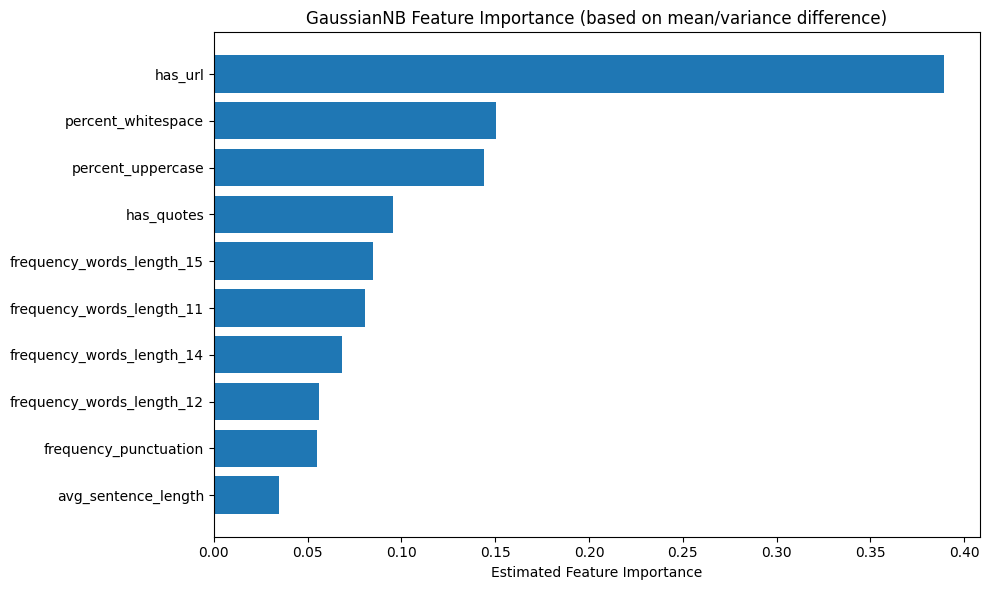

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)
mean_diff = np.abs(gnb.theta_[0] - gnb.theta_[1])  # absolute difference in means
var_sum = np.sqrt(gnb.var_[0] + gnb.var_[1])       # combined std dev
importance_scores = mean_diff / var_sum            # signal-to-noise ratio

# Sort scores and plot
features = x_train.columns
sorted_idx = np.argsort(importance_scores)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importance_scores[sorted_idx])
plt.xlabel("Estimated Feature Importance")
plt.title("GaussianNB Feature Importance (based on mean/variance difference)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Hyperparameter Tuning with Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# define parameter grid for GridSearchCV for GaussianNB
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search = GridSearchCV(gnb, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# fit the grid search to the training data
grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='accuracy', verbose=1)

In [30]:
# Best model after grid search
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Make predictions on the test set using the best model
y_pred = best_model.predict(x_test_scaled)
print("Accuracy after GridSearchCV:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Hyperparameters: {'var_smoothing': 1e-05}
Accuracy after GridSearchCV: 0.5619324876966798

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.94      0.68      7030
           1       0.79      0.20      0.32      7397

    accuracy                           0.56     14427
   macro avg       0.66      0.57      0.50     14427
weighted avg       0.66      0.56      0.49     14427



## K-fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# perform K-fold cross-validation (e.g., 5 folds)
cv_scores = cross_val_score(best_model, x_train_scaled, y_train, cv=5, scoring='accuracy')

# print cross-validation results
print(f"K-fold Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

K-fold Cross-validation scores: [0.5572691  0.56194767 0.56208301 0.55835716 0.55740404]
Mean accuracy: 0.5594121962260893


## Evaluate model with best parameter

In [37]:
# Make predictions on the test set using the best model
y_pred_best = best_model.predict(x_test_scaled)

# Evaluate accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy with best parameters: {:.4f}".format(accuracy_best))

Test accuracy with best parameters: 0.5619


## Save best model in joblib

In [38]:
import joblib

# Save the best model to a file
joblib.dump(best_model, 'best_gaussian_model.joblib')
print("Best model saved!")

Best model saved!


In [39]:
# Load the best model from file
best_model = joblib.load('best_gaussian_model.joblib')

# Use the model to make predictions again
y_pred = best_model.predict(x_test_scaled)